# Data Understanding

### Import Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

client = 'TOOL_CLIENT.csv'
sales  = 'TOOL_SALES.csv'
joint = 'TOOL_JOINT.csv'

In [2]:
# df_client = pd.read_csv(client)
# df_sales = pd.read_csv(sales)

# df = pd.merge(df_client, df_sales, on='CLIENT_ID')

df = pd.read_csv(joint)
df.head()

,CLIENT_ID,CLIENT_CREATE DATE,REGION,TRADE SECTOR,N_EMPLOYEES,ECONOMIC_POT,ECO_POT_CLASS,RISK_CAT,YYYYMM,ITEM_ID,FLG_TOOL,SALES_CHANNEL,NET,UNIT,FAMILY_CODE,GROUP_CODE,CANCELLED
0,9306,2005-11-15,BZ,11000,6,8659.81,D,3d,2017-09-01,12585,0,C,937.94,P,XBXV2EB,XBXV2EB0102,NaN
1,9306,2005-11-15,BZ,11000,6,8659.81,D,3d,2017-09-01,13431,0,C,641.09,P,XBXV2AB,XBXV2AB0102,NaN
2,9306,2005-11-15,BZ,11000,6,8659.81,D,3d,2017-09-01,1380,0,C,0.00,P,XBXV2EB,XBXV2EB0102,NaN
3,9306,2005-11-15,BZ,11000,6,8659.81,D,3d,2020-10-01,3493,1,C,1341.14,P,XBXV1AF,XBXV1AF0201,NaN
4,939,2005-11-15,LE,15500,2,681.26,E,3d,2017-05-01,8241,0,B,64.51,P,XAES4AA,XAES4AA0101,X


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2050449 entries, 0 to 2050448
Data columns (total 17 columns):
 #   Column              Dtype  
---  ------              -----  
 0   CLIENT_ID           int64  
 1   CLIENT_CREATE DATE  object 
 2   REGION              object 
 3   TRADE SECTOR        int64  
 4   N_EMPLOYEES         int64  
 5   ECONOMIC_POT        float64
 6   ECO_POT_CLASS       object 
 7   RISK_CAT            object 
 8   YYYYMM              object 
 9   ITEM_ID             int64  
 10  FLG_TOOL            int64  
 11  SALES_CHANNEL       object 
 12  NET                 float64
 13  UNIT                object 
 14  FAMILY_CODE         object 
 15  GROUP_CODE          object 
 16  CANCELLED           object 
dtypes: float64(2), int64(5), object(10)
memory usage: 265.9+ MB


In [4]:
# converting date columns to datetime
df['CLIENT_CREATE DATE'] = pd.to_datetime(df['CLIENT_CREATE DATE'])
df['YYYYMM'] = pd.to_datetime(df['YYYYMM'].astype(str), format='%Y-%m-%d')
df['CLIENT_ID'] = df['CLIENT_ID'].astype(str)
df['CANCELLED'] = df['CANCELLED'] == 'X'
df['UNIT'] = df['UNIT'] == 'P'

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2050449 entries, 0 to 2050448
Data columns (total 17 columns):
 #   Column              Dtype         
---  ------              -----         
 0   CLIENT_ID           object        
 1   CLIENT_CREATE DATE  datetime64[ns]
 2   REGION              object        
 3   TRADE SECTOR        int64         
 4   N_EMPLOYEES         int64         
 5   ECONOMIC_POT        float64       
 6   ECO_POT_CLASS       object        
 7   RISK_CAT            object        
 8   YYYYMM              datetime64[ns]
 9   ITEM_ID             int64         
 10  FLG_TOOL            int64         
 11  SALES_CHANNEL       object        
 12  NET                 float64       
 13  UNIT                bool          
 14  FAMILY_CODE         object        
 15  GROUP_CODE          object        
 16  CANCELLED           bool          
dtypes: bool(2), datetime64[ns](2), float64(2), int64(4), object(7)
memory usage: 238.6+ MB


In [6]:
# exporting the merged data

# df.to_csv('TOOL_JOINT.csv', index=False)

Create a new variable to identify client

Create a new variable to identify unique sales

In [7]:
# creating a new column for identifie the unique sales
df['SALES_ID'] = df['ECONOMIC_POT'].astype(str) + '_' + df['YYYYMM'].dt.strftime('%Y%m')

df.head()

,CLIENT_ID,CLIENT_CREATE DATE,REGION,TRADE SECTOR,N_EMPLOYEES,ECONOMIC_POT,ECO_POT_CLASS,RISK_CAT,YYYYMM,ITEM_ID,FLG_TOOL,SALES_CHANNEL,NET,UNIT,FAMILY_CODE,GROUP_CODE,CANCELLED,SALES_ID
0,9306,2005-11-15,BZ,11000,6,8659.81,D,3d,2017-09-01,12585,0,C,937.94,True,XBXV2EB,XBXV2EB0102,False,8659.81_201709
1,9306,2005-11-15,BZ,11000,6,8659.81,D,3d,2017-09-01,13431,0,C,641.09,True,XBXV2AB,XBXV2AB0102,False,8659.81_201709
2,9306,2005-11-15,BZ,11000,6,8659.81,D,3d,2017-09-01,1380,0,C,0.00,True,XBXV2EB,XBXV2EB0102,False,8659.81_201709
3,9306,2005-11-15,BZ,11000,6,8659.81,D,3d,2020-10-01,3493,1,C,1341.14,True,XBXV1AF,XBXV1AF0201,False,8659.81_202010
4,939,2005-11-15,LE,15500,2,681.26,E,3d,2017-05-01,8241,0,B,64.51,True,XAES4AA,XAES4AA0101,True,681.26_201705


In [8]:
# creating new dataframes with no canceled orders
no_canceled = df[df['CANCELLED'] == False]
no_canceled.head()

,CLIENT_ID,CLIENT_CREATE DATE,REGION,TRADE SECTOR,N_EMPLOYEES,ECONOMIC_POT,ECO_POT_CLASS,RISK_CAT,YYYYMM,ITEM_ID,FLG_TOOL,SALES_CHANNEL,NET,UNIT,FAMILY_CODE,GROUP_CODE,CANCELLED,SALES_ID
0,9306,2005-11-15,BZ,11000,6,8659.81,D,3d,2017-09-01,12585,0,C,937.94,True,XBXV2EB,XBXV2EB0102,False,8659.81_201709
1,9306,2005-11-15,BZ,11000,6,8659.81,D,3d,2017-09-01,13431,0,C,641.09,True,XBXV2AB,XBXV2AB0102,False,8659.81_201709
2,9306,2005-11-15,BZ,11000,6,8659.81,D,3d,2017-09-01,1380,0,C,0.00,True,XBXV2EB,XBXV2EB0102,False,8659.81_201709
3,9306,2005-11-15,BZ,11000,6,8659.81,D,3d,2020-10-01,3493,1,C,1341.14,True,XBXV1AF,XBXV1AF0201,False,8659.81_202010
7,8321,2005-11-15,LE,15500,2,681.26,E,T8,2018-04-01,6776,0,B,20.02,True,XBSI4AA,XBSI4AA0101,False,681.26_201804


In [9]:
# checking the number of unique sales per client
client_sales_count = no_canceled.groupby('CLIENT_ID')['SALES_ID'].nunique().sort_values(ascending=False)
print(client_sales_count)

CLIENT_ID
51708    60
19562    58
9659     58
27926    58
37126    57
         ..
39817     1
7320      1
73199     1
56057     1
1         1
Name: SALES_ID, Length: 85714, dtype: int64


In [10]:
client_sales_count.describe()

count    85714.000000
mean         5.147432
std          6.579728
min          1.000000
25%          1.000000
50%          2.000000
75%          6.000000
max         60.000000
Name: SALES_ID, dtype: float64

In [11]:
# filtering the clients with more than one sale
client_sales_count.drop(client_sales_count[client_sales_count < 2].index, inplace=True)

pluri_client = no_canceled[no_canceled['CLIENT_ID'].isin(client_sales_count.index)]
pluri_client['n_purchases'] = pluri_client.groupby('CLIENT_ID')['SALES_ID'].transform('nunique')

print(pluri_client.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1840920 entries, 0 to 2048901
Data columns (total 19 columns):
 #   Column              Dtype         
---  ------              -----         
 0   CLIENT_ID           object        
 1   CLIENT_CREATE DATE  datetime64[ns]
 2   REGION              object        
 3   TRADE SECTOR        int64         
 4   N_EMPLOYEES         int64         
 5   ECONOMIC_POT        float64       
 6   ECO_POT_CLASS       object        
 7   RISK_CAT            object        
 8   YYYYMM              datetime64[ns]
 9   ITEM_ID             int64         
 10  FLG_TOOL            int64         
 11  SALES_CHANNEL       object        
 12  NET                 float64       
 13  UNIT                bool          
 14  FAMILY_CODE         object        
 15  GROUP_CODE          object        
 16  CANCELLED           bool          
 17  SALES_ID            object        
 18  n_purchases         int64         
dtypes: bool(2), datetime64[ns](2), float64(2), int6

/var/folders/nr/4kkf0lts6dj62jvx76l5486h0000gn/T/ipykernel_17054/535403.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pluri_client['n_purchases'] = pluri_client.groupby('CLIENT_ID')['SALES_ID'].transform('nunique')


In [12]:
pluri_client.head()

,CLIENT_ID,CLIENT_CREATE DATE,REGION,TRADE SECTOR,N_EMPLOYEES,ECONOMIC_POT,ECO_POT_CLASS,RISK_CAT,YYYYMM,ITEM_ID,FLG_TOOL,SALES_CHANNEL,NET,UNIT,FAMILY_CODE,GROUP_CODE,CANCELLED,SALES_ID,n_purchases
0,9306,2005-11-15,BZ,11000,6,8659.81,D,3d,2017-09-01,12585,0,C,937.94,True,XBXV2EB,XBXV2EB0102,False,8659.81_201709,2
1,9306,2005-11-15,BZ,11000,6,8659.81,D,3d,2017-09-01,13431,0,C,641.09,True,XBXV2AB,XBXV2AB0102,False,8659.81_201709,2
2,9306,2005-11-15,BZ,11000,6,8659.81,D,3d,2017-09-01,1380,0,C,0.00,True,XBXV2EB,XBXV2EB0102,False,8659.81_201709,2
3,9306,2005-11-15,BZ,11000,6,8659.81,D,3d,2020-10-01,3493,1,C,1341.14,True,XBXV1AF,XBXV1AF0201,False,8659.81_202010,2
7,8321,2005-11-15,LE,15500,2,681.26,E,T8,2018-04-01,6776,0,B,20.02,True,XBSI4AA,XBSI4AA0101,False,681.26_201804,7


We have now a new dataset cointaining only client with more than one purchase

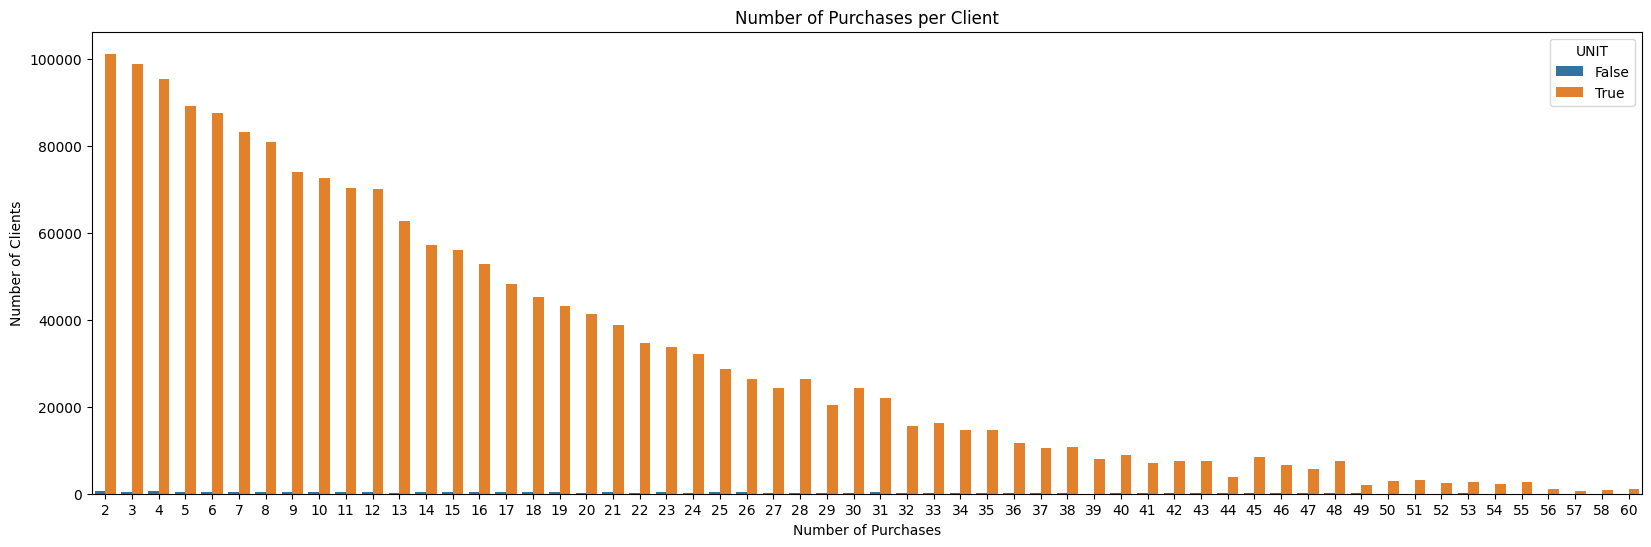

In [15]:
plt.figure(figsize=(20, 6))
sns.countplot(x='n_purchases', data=pluri_client, hue='UNIT')
plt.xlabel('Number of Purchases')
plt.ylabel('Number of Clients')
plt.title('Number of Purchases per Client')
plt.show()